In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from scipy.io import loadmat


In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
batch_size = 128
learning_rate = 3e-4
epochs = 20
latent_variable_dim = 100

In [0]:
#Code provided to load the data

def get_data_loader(dataset_location, batch_size):
    URL = "http://ufldl.stanford.edu/housenumbers/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "test"]:
        filename = "%s_32x32.mat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        
        f=loadmat(filepath,mat_dtype=True)
        x = f["X"].astype('float32')#.readlines()
        x=np.transpose(x, (3, 2,0,1))
        x=x/256
        #with open(filepath) as f:
        #    lines = f.readlines()
        #x = lines_to_np_array(lines).astype('float32')
        #x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        print(x.shape)

        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        print(dataset)
        dataset_loader = data_utils.DataLoader(dataset, batch_size = batch_size, shuffle = splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [0]:
trainloader, validloader = get_data_loader("SVHN", 64)
#trainloader = get_data_loader("SVHN", batch_size)

Using downloaded and verified file: SVHN/train_32x32.mat
(73257, 3, 32, 32)
Using downloaded and verified file: SVHN/test_32x32.mat
(26032, 3, 32, 32)


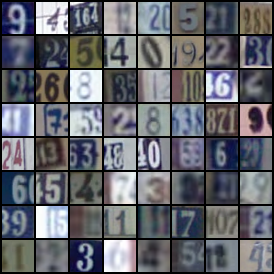

In [0]:
# Fixed input for debugging
fixed_x = next(iter(trainloader))
#print(fixed_x)
save_image(fixed_x[0], 'real_image.png')

Image('real_image.png')

We use the tutorial provided in the following website to help us implement our VAE :
http://hameddaily.blogspot.com/2018/12/yet-another-tutorial-on-variational.html
and https://github.com/pytorch/examples/blob/master/vae/main.py

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # For encoder
        self.fcE1   = nn.Linear(in_features=256, out_features=2*latent_variable_dim)
        self.convE1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1)
        self.convE2 = nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=3)
        self.convE3 = nn.Conv2d(in_channels=64 , out_channels=256, kernel_size=5)
                
        # For decoder
        self.fcD1   = nn.Linear(in_features=latent_variable_dim, out_features=256)
        self.convD1 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=5, padding=4)
        self.convD2 = nn.Conv2d(in_channels=64 , out_channels=32, kernel_size=3, padding=2)
        self.convD3 = nn.Conv2d(in_channels=32 , out_channels=16, kernel_size=3, padding=2)        
        self.convD4 = nn.Conv2d(in_channels=16 , out_channels=3 , kernel_size=3, padding=4)
        self.upsampling = nn.UpsamplingBilinear2d(scale_factor=2)

    def encode(self, x):
        h1 = F.elu(self.convE1(x))
        h2 = F.avg_pool2d(h1, kernel_size=2, stride=2)
        h3 = F.elu(self.convE2(h2))
        h4 = F.avg_pool2d(h3, kernel_size=2, stride=2)
        h5 = F.elu(self.convE3(h4))
        h5 = h5.reshape(-1,256)
        h6 = self.fcE1(h5) 
        mu = h6[:,:latent_variable_dim]
        logvar = h6[:,latent_variable_dim:]
        return  mu , logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h7 = F.elu(self.fcD1(z))
        h7 = h7.reshape(z.shape[0], 256, 1, 1)
        h8 = F.elu(self.convD1(h7))
        h9 = self.upsampling(h8)
        h10 = F.elu(self.convD2(h9))
        h11 = self.upsampling(h10)
        h12 = F.elu(self.convD3(h11))
        return torch.sigmoid(self.convD4(h12))

    def forward(self, x):
        mu, logvar = self.encode(x)
        #print(mu.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
model = VAE()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 1024), x.view(-1, 1024), reduction='sum')
    KLD = 0.5 * torch.sum(-1 - logvar + mu**2 + logvar.exp())

    return BCE + KLD

In [0]:
log_interval = batch_size

for epoch in range(epochs):
    model.train()
    train_loss = 0
    valid_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
      
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            data = data[0].to(device)
            recon_batch, mu, logvar = model(data)
            valid_loss += loss_function(recon_batch, data, mu, logvar).item()
    
    print('====> Epoch: {} Average per-instance ELBO Train: {:.2f} ------- Average per-instance ELBO Validation: {:.2f}'.format(epoch, -train_loss / len(trainloader.dataset), -valid_loss / len(validloader.dataset) ))
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


====> Epoch: 0 Average per-instance ELBO Train: -1994.32 ------- Average per-instance ELBO Validation: -1933.05
====> Epoch: 1 Average per-instance ELBO Train: -1970.77 ------- Average per-instance ELBO Validation: -1923.81
====> Epoch: 2 Average per-instance ELBO Train: -1967.25 ------- Average per-instance ELBO Validation: -1920.50
====> Epoch: 3 Average per-instance ELBO Train: -1965.93 ------- Average per-instance ELBO Validation: -1918.91
====> Epoch: 4 Average per-instance ELBO Train: -1964.88 ------- Average per-instance ELBO Validation: -1918.28
====> Epoch: 5 Average per-instance ELBO Train: -1964.13 ------- Average per-instance ELBO Validation: -1916.97
====> Epoch: 6 Average per-instance ELBO Train: -1963.66 ------- Average per-instance ELBO Validation: -1916.29
====> Epoch: 7 Average per-instance ELBO Train: -1963.24 ------- Average per-instance ELBO Validation: -1916.19
====> Epoch: 8 Average per-instance ELBO Train: -1962.94 ------- Average per-instance ELBO Validation: -

torch.Size([3, 274, 274])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


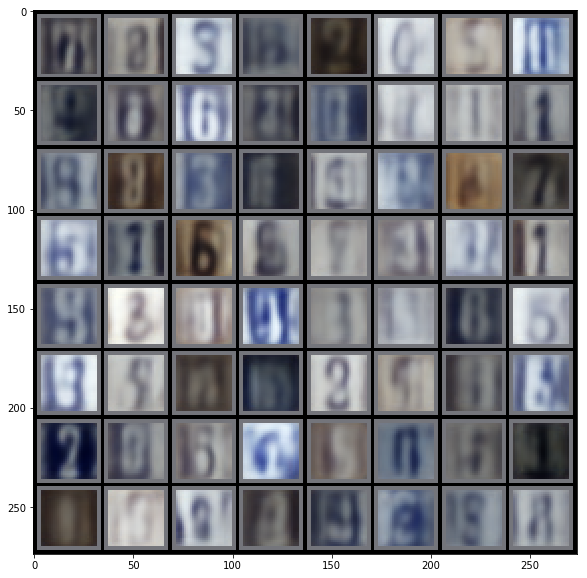

In [0]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

z=torch.randn(64,100, device=device)
#print(z.shape)
#z=model.reparameterize( 0.1*torch.ones(64,100),0.1*torch.ones(64,100)).to(device)
#print(z.shape)
#img=model.decode(z)
fake=model.decode(z).detach().cpu()
#fake = netG(z).detach().cpu()
fake=vutils.make_grid(fake, padding=2, normalize=True)
print(fake.shape)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(fake,(1,2,0)))

3.1.Provide visual samples (VAE)

In [0]:
import os
directory='VAE'
if not os.path.exists(directory):
    os.makedirs(directory)
    
Num_Img=1000
z=torch.randn(Num_Img,100, device=device)
fake=model.decode(z).detach().cpu()
print(fake.shape)

for ii in range(Num_Img):
  save_path = './VAE/fake_samples_epoch_%03d.png' % (ii)
  vutils.save_image(fake.data[ii], save_path)
  
  

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


torch.Size([1000, 3, 32, 32])


In [0]:
import os
directory='VAE_64_64'
if not os.path.exists(directory):
    os.makedirs(directory)
    
epoch=100    
for ii in range(epoch):
  Num_Img=64
  z=torch.randn(Num_Img,100, device=device)
  fake=model.decode(z).detach().cpu()
  fake=vutils.make_grid(fake, padding=2, normalize=True)
  #print(fake.shape)

  save_path = './%s/fake_samples_epoch_%03d.png' % (directory,ii)
  vutils.save_image(fake.data, save_path)

  

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


3.2.We want to see if the model has learned a disentangled representation in thelatent space.

In [0]:
import os
directory='VAE_Eps'
if not os.path.exists(directory):
    os.makedirs(directory)

Eps=100
epoch=100# number of hidden space   
for ii in range(epoch):
  Num_Img=64
  z=torch.randn(Num_Img, 100, device=device)
  #print(z.shape)
  #Make small perturbationsto your sample z
  z[:,ii]=z[:,ii]+Eps
  fake=model.decode(z).detach().cpu()
  fake=vutils.make_grid(fake, padding=2, normalize=True)
  #print(fake.shape)

  save_path = './%s/fake_samples_dim_%03d.png' % (directory,ii)
  vutils.save_image(fake.data, save_path)

  

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [0]:
#For report presentation
import os
directory='VAE_Eps1'
if not os.path.exists(directory):
    os.makedirs(directory)
    
epoch=100# number of hidden space   
Num_Img=8
z=torch.randn(Num_Img, 100, device=device)

for ii in range(epoch):
  fake_lst=[]
  for Eps in [-5,-2,0,0.2,0.5,.8,1,3,5,20]:
    #print(z.shape)
    #Make small perturbationsto your sample z
    z[:,ii]=z[:,ii]+Eps
    fake=model.decode(z).detach().cpu()
    fake_lst.append(fake)

    
  fake=torch.stack(fake_lst)
  #print(fake.shape)
  #print(fake.shape)
  fake=fake.view(10*8,3,32,32)
  #print(fake3.shape)
  fake3=vutils.make_grid(fake, padding=2, normalize=True)

  save_path = './%s/fake3_samples_All_%2f_%d_.png' % (directory,Eps,ii)
  vutils.save_image(fake3.data, save_path)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


3.3.Compare between interpolating in the data space and in the latent space.

In [0]:
#In the latent space
import os
directory='VAE_alpha'
if not os.path.exists(directory):
    os.makedirs(directory)
    
Num_Img=8
fake_lst=[]

nz=100# number of hidden space
z0=torch.randn(Num_Img, nz, device=device)
z1=torch.randn(Num_Img, nz, device=device)
  
for Alpha in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  
  z_alp=Alpha*z0+(1-Alpha)*z1

  fake=model.decode(z_alp).detach().cpu()
  fake_lst.append(fake)

fake=torch.stack(fake_lst)
#print(fake.shape)
fake=fake.view(11*8,3,32,32)
#print(fake3.shape)
fake3=vutils.make_grid(fake, padding=2, normalize=True)

save_path = './%s/fake3_samples_All_alpha_%2f_laten.png' % (directory,Alpha)
vutils.save_image(fake3.data, save_path)


torch.Size([11, 8, 3, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [0]:
# In the data space
import os
directory='VAE_alpha'
if not os.path.exists(directory):
    os.makedirs(directory)
    
Num_Img=8
fake_lst=[]
z0=torch.randn(Num_Img, nz, device=device)
z1=torch.randn(Num_Img, nz, device=device)

for Alpha in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  
  fake_z0=model.decode(z0).detach().cpu()

  fake_z1=model.decode(z1).detach().cpu()

  fake=Alpha*fake_z0+(1-Alpha)*fake_z1
  fake_lst.append(fake)
  
  
fake=torch.stack(fake_lst)
fake=fake.view(11*8,3,32,32)
#print(fake3.shape)
fake3=vutils.make_grid(fake, padding=2, normalize=True)

save_path = './%s/fake3_samples_All_alpha_%2f_data.png' % (directory,Alpha)
vutils.save_image(fake3.data, save_path)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
